In [1]:
import numpy as np

In [2]:
import riemann

In [3]:
class RJState:
    def __init__(self, param, idx):
        self.param = param
        assert idx > 0
        self.idx = idx
        
    def dimension(self, idx=None):
        if idx is None:
            return self.idx
        return idx 

In [8]:
class JumpProposal:
    def __init__(self, mapping, matching_prop):
        self.mapping = mapping        
        self.matching_prop = matching_prop
            
    def propose(self, state, new_k):
        k = state.idx
        u = self.matching_prop.match(state, new_k)
        if u is not None: # moving to higher dimension
            new_state = self.mapping.forward(state, u, new_k)
            logqratio = self.mapping.log_det(state, u, new_k)\
                        - self.matching_prop.logp(k, new_k, u)
        else: # moving to lower dimension
            new_state, u = self.mapping.backward(state, new_k)
            logqratio = self.matching_prop.logp(k, new_k, u)\
                        - self.mapping.log_det(new_state, u, k)
        return new_state, logqratio

In [9]:
class RJProposal(riemann.Proposal):
    def __init__(self, move_prop, jump_prop, within_prop):
        self.move_prop = move_prop
        self.within_prop = within_prop
        self.jump_prop = jump_prop
            
    def propose(self, state, **kwargs):
        new_k = self.move_prop.move(state)
        k = state.idx
        if new_k == k:
            new_state, logqratio = self.within_prop.propose(state)
        else:
            new_state, logqratio = self.jump_prop.propose(state, new_k)
        return new_state, logqratio + self.move_prop.logp(k, new_k)

# Example

In [10]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from dbo import param_serial, gmm_utils

In [11]:
gmm = gmm_utils.GMM(weights=[0.4,0.6], means=[[0.], [0.9]], covariances=[[[0.01]], [[0.01]]])

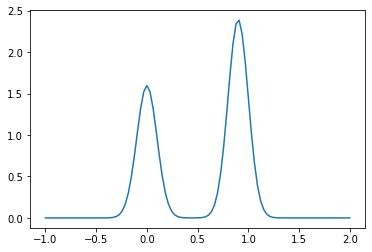

In [12]:
import matplotlib.pyplot as plt

query_x = np.linspace(-1,2,100)[:,None]
pdf_query_x = gmm.density(gmm_utils.ensure_torch(query_x)).numpy()

plt.plot(query_x, pdf_query_x)

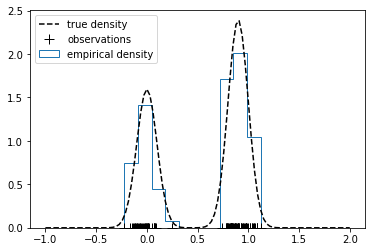

In [14]:
n_obs = 100
obs = gmm.sample(n_obs)

plt.plot(query_x, pdf_query_x, 'k--', label="true density")
plt.plot(obs.numpy(), np.zeros(len(obs)), 'k+', ms=10, label="observations")
plt.hist(obs.numpy(), density=True, histtype='step', label="empirical density")
plt.legend()

## Model

In [15]:
true_cov_factors = torch.cholesky(gmm.covariances)
true_params = param_serial.GMMParameters.serialise(gmm.weights, gmm.means, true_cov_factors)
true_k = len(gmm.weights)
true_state = RJState(true_params, true_k)

In [16]:
class RJGMModel(riemann.Model):
    def __init__(self, data, k_prior, precision_prior):
        self.data = data
        d = data.shape[-1]
        self.k_prior = k_prior
        self.sample_mean = data.mean(axis=0)
        self.sample_covariance = torch.tensor(np.cov(data.T), dtype=torch.get_default_dtype()).view(d,d)
        self.means_prior = torch.distributions.MultivariateNormal(self.sample_mean, 
                                                             covariance_matrix=self.sample_covariance)
        self.precision_prior = precision_prior
    
    @staticmethod
    def transform_param(param, n_comp):
        weights, means, covariances = param_serial.GMMParameters.deserialise(param, n_comp)
        weights = weights/weights.sum()
        covariances = torch.matmul(covariances, covariances.transpose(-2, -1))
        return weights, means, covariances
        
    def log_likelihood(self, state):
        candidate_gmm = gmm_utils.GMM(*self.transform_param(state.param, state.idx))
        return candidate_gmm.density(self.data).log().sum().item()
    
    def log_prior(self, state):
        k = state.idx # number of mixture components
        candidate = gmm_utils.GMM(*self.transform_param(state.param, state.idx))
        log_p_k = self.k_prior.log_prob(gmm_utils.ensure_torch(k-1)).item()
        log_p_w = torch.distributions.Dirichlet(torch.ones([k])).log_prob(candidate.weights.view(-1)).item()
        log_p_means = self.means_prior.log_prob(candidate.means).sum().item()
        log_p_precision = self.precision_prior.log_prob(1./candidate.covariances).sum().item() # Assuming 1-D data!
#         print(log_p_k, log_p_w, log_p_means, log_p_precision)
        return log_p_k + log_p_w + log_p_means + log_p_precision

In [18]:
model = RJGMModel(obs, k_prior = torch.distributions.Geometric(torch.tensor(.4)),
                 precision_prior=torch.distributions.Gamma(concentration=100., rate=1.))
# model.log_posterior(true_state), model.log_posterior(state)

In [19]:
gmm_utils.GMM(*model.transform_param(true_state.param, true_state.idx)).weights

tensor([[0.4000],
        [0.6000]])

In [20]:
torch.distributions.Geometric(torch.tensor(.4)).log_prob(torch.tensor(0.))

tensor(-0.9163)

## Sampler

In [21]:
class GenericMapping:
    def __init__(self, means, cov_factors):
        self.means = means
        self.cov_factors = cov_factors
        
    def forward(self, state, u, k_high):
        k_low = state.idx - 1
        k_high = k_high - 1
        new_param = self.means[k_high]\
        + torch.mm(self.cov_factors[k_high],
                   torch.cat([torch.triangular_solve((state.param-self.means[k_low]).view(-1,1), 
                                                      self.cov_factors[k_low]).solution, u.view(-1,1)])).view(-1)
        return RJState(new_param, k_high+1)
    
    def backward(self, state, k_low):
        k_high = state.idx-1
        k_low = k_low - 1
        new_dim = self.means[k_low].shape[-1]
        diff = torch.triangular_solve((state.param-self.means[k_high]).view(-1,1), 
                                      self.cov_factors[k_high]).solution
        new_param = self.means[k_low] + torch.mm(self.cov_factors[k_low],diff[:new_dim]).view(-1)
        u = diff[new_dim:]
        return RJState(new_param, k_low+1), u
    
    def log_det(self, state, u, k_high):
        k_low = state.idx-1
        return torch.logdet(self.cov_factors[k_high-1])-torch.logdet(self.cov_factors[k_low])

In [22]:
import math

class GenericMatchingProp:
    def __init__(self, base_dim):
        self.base_dim = base_dim
        
    def match(self, state, new_k):
        if new_k > state.idx:
            return torch.randn(abs(new_k - state.idx)*self.base_dim)
        return
    
    def logp(self, k, new_k, u):
        return -0.5*(u*u).sum() - 0.5*abs(new_k-k)*math.log(2*math.pi)

In [23]:
class MoveProp:
    def __init__(self, max_k, no_jump_ratio=1):
        self.max_k = max_k
        self.move_p = np.array([1./max_k]*max_k)
        self.no_jump_ratio = no_jump_ratio
    
    def move(self, state):
        p = np.ones((self.max_k,))
        p[state.idx-1]*=self.no_jump_ratio
        self.move_p = p/p.sum()
        return np.random.choice(self.max_k, p=self.move_p)+1
    
    def logp(self, k, new_k):
        return np.log(self.move_p[new_k-1])

In [24]:
class RandomWalk:
    def __init__(self, proposal_sd=1.):
        self.proposal_sd = proposal_sd
    
    def propose(self, state):
        new_param = state.param + torch.randn_like(state.param)*self.proposal_sd
        log_q_ratio = 0
        return RJState(new_param, state.idx), log_q_ratio

In [26]:
max_n_comp = 3
dim = int(true_params.numel()/gmm.weights.numel())
g_means = [torch.zeros(dim*n) for n in range(1,max_n_comp+1)]
g_covs = [0.1*torch.eye(dim*n) for n in range(1,max_n_comp+1)]
generic_map = GenericMapping(g_means, g_covs)

In [27]:
u = torch.randn(dim)
generic_map.forward(true_state, u, max_n_comp).param

tensor([ 0.4000,  0.0000,  0.1000,  0.6000,  0.9000,  0.1000, -0.1206,  0.0343,
         0.0749])

In [28]:
jump_prop = JumpProposal(generic_map, GenericMatchingProp(dim))

In [29]:
no_jump_ratio = 1.1
move_prop = MoveProp(max_n_comp, no_jump_ratio)
move_prop.move(true_state)

3

In [31]:
rj_prop = RJProposal(move_prop, jump_prop, RandomWalk(0.01))

In [32]:
n_samples = 100
sample = RJState(torch.rand(3), 1)
for i in range(n_samples):
    sample, _ = rj_prop.propose(sample)
    print(sample.param.numpy())

[ 0.57193875  0.8307876   0.81441563 -0.18782908  0.10366779 -0.15856439]
[ 0.5652433   0.83422196  0.8121826  -0.1864578   0.11433209 -0.16522467]
[0.5652433  0.83422196 0.8121826 ]
[ 0.5652433   0.83422196  0.8121826   0.00573649  0.07647062 -0.12671728
  0.02948124 -0.04569351 -0.12232232]
[ 0.5652433   0.83422196  0.8121826   0.00573649  0.07647062 -0.12671728]
[ 0.5773086   0.84254354  0.8151819  -0.00493196  0.06772339 -0.11720793]
[ 0.57589287  0.84580106  0.81916434 -0.00600247  0.08043116 -0.11319408]
[0.57589287 0.84580106 0.8191643 ]
[0.58619624 0.8411593  0.8256137 ]
[ 0.58619624  0.8411593   0.8256137   0.04210252  0.06400667 -0.22800915]
[ 0.58619624  0.8411593   0.8256137   0.04210252  0.06400667 -0.22800915
  0.00884812 -0.08156482  0.03176728]
[ 0.58619624  0.8411593   0.8256137   0.04210252  0.06400667 -0.22800915]
[ 0.58619624  0.8411593   0.8256137   0.04210252  0.06400667 -0.22800915
 -0.01015163  0.15368402 -0.24870782]
[ 0.5930666   0.8515438   0.825342    0.0526

In [33]:
initial_n_comp = 2
initial_state = RJState(torch.rand(initial_n_comp*dim), initial_n_comp)
rj_sampler = riemann.Sampler(model, rj_prop, initial_state)
rj_sampler.run(1000)

In [34]:
from tqdm import trange

n_samples = 10000
samples = [None]*n_samples
for i in trange(n_samples):
    state, logp = rj_sampler.sample()
#     print(model.transform_param(state.param, state.idx), logp) 
    samples[i] = state

100%|██████████| 10000/10000 [00:11<00:00, 844.92it/s]


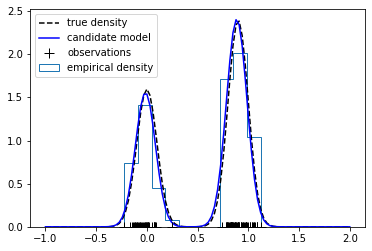

In [35]:
pdf_query_x = gmm.density(gmm_utils.ensure_torch(query_x)).numpy()
candidate_gmm = gmm_utils.GMM(*model.transform_param(state.param, state.idx))
candidate_query_x = candidate_gmm.density(gmm_utils.ensure_torch(query_x)).numpy()

plt.plot(query_x, pdf_query_x, 'k--', label="true density")
plt.plot(query_x, candidate_query_x,'b-', label="candidate model")
plt.plot(obs.numpy(), np.zeros(len(obs)), 'k+', ms=10, label="observations")
plt.hist(obs.numpy(), density=True, histtype='step', label="empirical density")
plt.legend()

In [36]:
candidate_gmm.weights, candidate_gmm.means, candidate_gmm.covariances

(tensor([[0.6137],
         [0.3863]]), tensor([[ 0.8858],
         [-0.0143]]), tensor([[[0.0104]],
 
         [[0.0098]]]))

<StemContainer object of 3 artists>

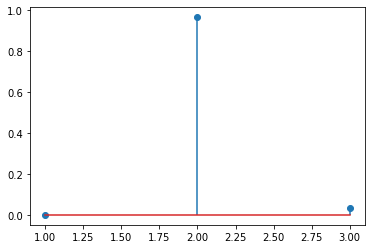

In [37]:
k_samples = [s.idx for s in samples]
counts,_ = np.histogram(k_samples, range=[1,max_n_comp], bins=max_n_comp)

plt.stem(np.arange(1,max_n_comp+1), counts/counts.sum(), use_line_collection=True)